# Introduction

## In this notebook, Insurance Customer Churn dataset will be used to classify whether a customer has a possibility of churning or not. The stpes are follows:

* read the dataset and use pandas profiling to explore the predictor variables and response variable.  
* Use Explorative Data Anlysis techniques (EDA) like unimportant feature removing, missing value imputation, target class balancing, categorical encoding of categorical variables, and scaling of numerical variables.  
* Train plain Logistic Regression, Extreme Gradient Boosting, and Support Vector Machine using train set obtained through train test split.  
* Define parameters dictionary for each model and employ grid search with 5-fold cross validation to improve model performance and corrsponding best parameters.
* Obtain best model and predict test set class with the best model and parameters.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df=pd.read_csv("Insurance Churn.csv", skiprows=0)
df.head()

,y,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x75,x76,x77,x78,x79,x80,x81,x82,x83,x84
0,0,0.165254,18.060003,Wed,1.077380,-1.339233,-1.584341,0.01%,0.220784,1.816481,...,-0.162668,1.079562,2.770844,-0.397427,no,5.492487,NaN,7.627730,0,104.251338
1,1,2.441471,18.416307,Friday,1.482586,0.920817,-0.759931,0.01%,1.192441,3.513950,...,1.252022,1.223852,3.703013,0.656651,no,3.346429,4.321172,10.505284,1,101.230645
2,1,4.427278,19.188092,Thursday,0.145652,0.366093,0.709962,-8.00E-06,0.952323,0.782974,...,0.657292,-0.353469,3.997183,2.059615,no,4.456565,NaN,7.810979,0,109.345215
3,0,3.925235,19.901257,Tuesday,1.763602,-0.251926,-0.827461,-0.01%,-0.520756,1.825586,...,2.066346,1.761266,2.933707,0.899392,no,4.100022,1.151085,9.178325,1,103.021970
4,0,2.868802,22.202473,Sunday,3.405119,0.083162,1.381504,0.01%,-0.732739,2.151990,...,0.663113,-0.952377,2.922302,3.003595,yes,3.234033,2.074927,11.702664,0,92.925935


In [3]:
from pandas_profiling import ProfileReport
profile = ProfileReport(df, minimal=True)
profile.to_file("Insurance_churn.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [4]:
df.y.value_counts()

0    34197
1     5803
Name: y, dtype: int64

In [5]:
df_0 = df[df['y']==0]
df_1=df[df['y']==1]
df_0=df_0.sample(n=5803,random_state=123)

In [6]:
df_balanced = pd.concat([df_0,df_1],axis=0).sample(frac=1).reset_index().drop(['index'],axis=1)

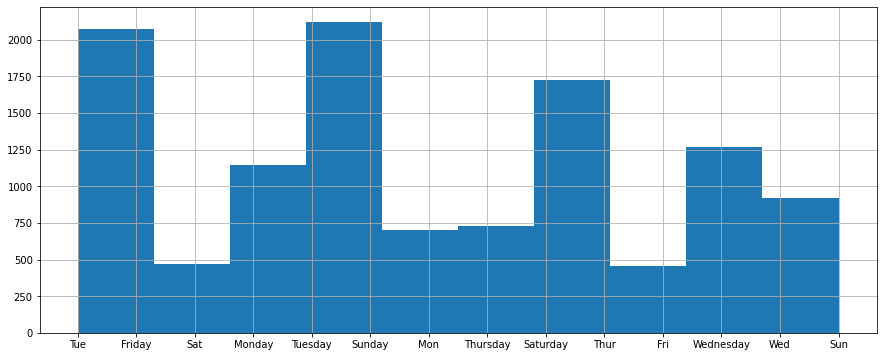

In [7]:
df_balanced.x3.hist(figsize=(15,6));

In [8]:
df_balanced = df_balanced.replace({'x3':{'Mon':'Monday','Tue':'Tuesday','Wed':'Wednesday','Thur':'Thursday','Fri':'Friday','Sat':'Saturday','Sun':'Sunday'}})
df_balanced.x3.unique()

array(['Tuesday', 'Friday', 'Saturday', 'Monday', 'Sunday', 'Thursday',
       'Wednesday'], dtype=object)

In [9]:
df_balanced.select_dtypes(include=['object']).head()

,x3,x7,x18,x23,x30,x32,x37,x54,x59,x67,x79
0,Tuesday,-0.01%,($806.37),NaN,no,NaN,5-10 miles,August,progressive,ford,no
1,Friday,0.00%,($485.95),female,no,North Dakota,5-10 miles,July,progressive,subaru,no
2,Saturday,0.00%,$543.23,male,no,Arkansas,5-10 miles,July,progressive,toyota,no
3,Monday,0.00%,$595.70,female,no,Illinois,5-10 miles,June,progressive,subaru,no
4,Tuesday,0.02%,($912.51),male,no,Vermont,5-10 miles,July,progressive,nissan,no


In [10]:
df_balanced.x37.unique()

array(['5-10 miles'], dtype=object)

In [11]:
df_balanced.drop(['x37'], axis=1, inplace=True)

In [12]:
df_balanced['x7'] = df_balanced['x7'].replace({'%': ''}, regex=True).astype(float)
df_balanced['x18'] = df_balanced['x19'].replace({'\$': ''}, regex=True).astype(float)

In [13]:
df_balanced[['x7','x18']].dtypes

x7     float64
x18    float64
dtype: object

In [14]:
df_convert_cat = df_balanced[['x53','x83']]

In [15]:
df_categorical = pd.concat([df_convert_cat,df_balanced.select_dtypes(include=['object'])],axis=1)
df_categorical.head()

,x53,x83,x3,x23,x30,x32,x54,x59,x67,x79
0,0,1,Tuesday,NaN,no,NaN,August,progressive,ford,no
1,0,1,Friday,female,no,North Dakota,July,progressive,subaru,no
2,0,0,Saturday,male,no,Arkansas,July,progressive,toyota,no
3,0,1,Monday,female,no,Illinois,June,progressive,subaru,no
4,1,0,Tuesday,male,no,Vermont,July,progressive,nissan,no


In [16]:
df_categorical.isna().any()

x53    False
x83    False
x3     False
x23     True
x30    False
x32     True
x54    False
x59    False
x67     True
x79    False
dtype: bool

In [17]:
df_categorical.dtypes

x53     int64
x83     int64
x3     object
x23    object
x30    object
x32    object
x54    object
x59    object
x67    object
x79    object
dtype: object

In [18]:
df_categorical['x23']=df_categorical['x23'].fillna("Other")
df_categorical['x32']=df_categorical['x32'].fillna("Other")
df_categorical['x67']=df_categorical['x67'].fillna("Other")
df_categorical.tail()

,x53,x83,x3,x23,x30,x32,x54,x59,x67,x79
11601,0,1,Friday,female,no,Rhode Island,December,allstate,mercedes,no
11602,0,1,Sunday,female,no,Pennsylvania,February,progressive,toyota,no
11603,0,1,Sunday,male,no,Ohio,January,farmers,subaru,no
11604,0,1,Saturday,female,no,Illinois,August,geico,Other,no
11605,0,0,Wednesday,female,no,California,December,allstate,mercedes,no


In [19]:
cat_columns = ['x3','x23','x30','x32','x53','x54','x59','x67','x79','x83']
df_categorical = df_categorical[cat_columns].astype('category')
df_categorical.dtypes

x3     category
x23    category
x30    category
x32    category
x53    category
x54    category
x59    category
x67    category
x79    category
x83    category
dtype: object

In [20]:
df_categorical.head()

,x3,x23,x30,x32,x53,x54,x59,x67,x79,x83
0,Tuesday,Other,no,Other,0,August,progressive,ford,no,1
1,Friday,female,no,North Dakota,0,July,progressive,subaru,no,1
2,Saturday,male,no,Arkansas,0,July,progressive,toyota,no,0
3,Monday,female,no,Illinois,0,June,progressive,subaru,no,1
4,Tuesday,male,no,Vermont,1,July,progressive,nissan,no,0


In [21]:
df_numeric = df_balanced.drop(['y','x3','x23','x30','x32','x53','x54','x59','x67','x79','x83'], axis=1)
df_numeric.head()

,x1,x2,x4,x5,x6,x7,x8,x9,x10,x11,...,x73,x74,x75,x76,x77,x78,x80,x81,x82,x84
0,1.721528,19.097326,-1.589676,-1.321195,-0.692398,-0.01,-2.220408,6.425238,-1.744801,104.134658,...,104.329190,54.684156,-0.523806,0.669408,4.677346,NaN,2.511178,NaN,9.645156,103.692440
1,4.827217,17.996120,1.896966,0.369205,-2.223903,0.00,-0.942040,7.281404,-1.220046,108.653567,...,104.544842,46.859852,-0.168161,2.191143,4.751604,2.020579,3.482511,-2.242894,9.921772,103.449300
2,3.294479,22.081439,-2.580581,0.991656,-0.382962,0.00,-0.317619,3.074653,-1.393332,104.872156,...,101.281723,58.464959,-0.059424,1.929739,3.585813,0.872849,2.679974,-1.500178,7.331525,101.406780
3,4.409323,21.182549,0.069971,-2.706424,-3.348673,0.00,-0.547780,3.461307,-0.140873,92.207625,...,116.992520,56.985797,0.829830,1.365352,3.386128,3.421502,1.746073,NaN,11.392558,92.591430
4,1.091913,21.993371,1.064042,0.135222,1.445551,0.02,0.898725,0.471560,1.145356,76.867699,...,78.896487,62.451124,-0.946466,0.108289,3.581693,0.452060,2.719022,0.290896,8.558959,93.702225


In [22]:
num_nan_cols = [i for i in df_numeric.columns if df_numeric[i].isnull().any()]
len(num_nan_cols)

23

In [23]:
length=df_numeric.shape[1]
for i in range (length):
    df_numeric.iloc[:,i].fillna(df_numeric.iloc[:,i].mean(), inplace = True)

In [24]:
df_numeric.columns[df_numeric.isna().any()]

Index([], dtype='object')

In [25]:
df_numeric.tail()

,x1,x2,x4,x5,x6,x7,x8,x9,x10,x11,...,x73,x74,x75,x76,x77,x78,x80,x81,x82,x84
11601,-0.517406,21.735390,-0.141947,-0.094025,-0.376146,0.000000,0.232776,3.204474,-0.782922,102.675251,...,93.236271,50.036564,0.284343,0.851807,3.040437,-1.025044,2.916960,1.018664,11.001907,92.768862
11602,1.103392,19.248111,0.355693,0.699185,1.912878,-0.000003,0.803048,2.965294,0.836132,91.648904,...,93.798694,48.194354,0.654685,0.934797,2.780186,1.278964,3.960518,-0.763064,11.189611,104.426632
11603,4.963571,17.971175,-1.172793,0.464863,-0.750046,0.000000,-1.023858,1.944467,0.968899,74.962284,...,99.852713,47.978865,1.802629,1.219974,4.205629,-0.214840,3.312904,3.945396,10.997828,103.126563
11604,3.608483,22.803951,1.771391,0.176076,0.391599,0.010000,0.556532,2.394502,1.587160,114.982218,...,99.852713,61.362873,0.167402,-1.118985,1.297729,3.503218,3.468713,0.030914,10.797072,93.233901
11605,1.616157,19.289483,0.378098,1.122439,0.034626,-0.000003,1.706210,5.577380,2.215167,95.379552,...,103.783157,39.927265,-1.143548,1.369875,2.563798,0.016388,4.585103,0.114797,12.250879,104.478542


In [26]:
columns_scaling = df_numeric.columns
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df_numeric[columns_scaling] = scaler.fit_transform(df_numeric[columns_scaling])
df_numeric.head()

,x1,x2,x4,x5,x6,x7,x8,x9,x10,x11,...,x73,x74,x75,x76,x77,x78,x80,x81,x82,x84
0,0.299994,0.428332,0.360521,0.335090,0.411843,0.375,0.292847,0.494808,0.188238,0.548099,...,0.550324,0.649491,0.446713,0.473130,0.719362,0.549738,0.340322,0.497705,0.484874,0.594773
1,0.520667,0.340698,0.714858,0.495214,0.254938,0.500,0.404922,0.540663,0.261160,0.597225,...,0.553062,0.433887,0.488711,0.633895,0.728547,0.723396,0.419514,0.318072,0.502216,0.588441
2,0.411759,0.665809,0.259818,0.554177,0.443545,0.500,0.459665,0.315353,0.237080,0.556117,...,0.511635,0.753674,0.501551,0.606279,0.584344,0.623948,0.354084,0.374660,0.339821,0.535251
3,0.490974,0.594275,0.529186,0.203874,0.139703,0.500,0.439487,0.336062,0.411126,0.418438,...,0.711092,0.712914,0.606562,0.546654,0.559644,0.844783,0.277944,0.497705,0.594427,0.305684
4,0.255257,0.658801,0.630211,0.473050,0.630879,0.750,0.566303,0.175933,0.589864,0.251676,...,0.227444,0.863515,0.396802,0.413850,0.583835,0.587488,0.357268,0.511122,0.416775,0.334611


In [27]:
df_numcat = pd.concat([df_numeric, df_categorical], axis=1 )
df_numcat.tail()

,x1,x2,x4,x5,x6,x7,x8,x9,x10,x11,...,x3,x23,x30,x32,x53,x54,x59,x67,x79,x83
11601,0.140908,0.638271,0.507649,0.451335,0.444243,0.500000,0.507918,0.322306,0.321904,0.532234,...,Friday,female,no,Rhode Island,0,December,allstate,mercedes,no,1
11602,0.256072,0.440332,0.558223,0.526472,0.678758,0.499962,0.557914,0.309496,0.546893,0.412364,...,Sunday,female,no,Pennsylvania,0,February,progressive,toyota,no,1
11603,0.530355,0.338713,0.402888,0.504276,0.405937,0.500000,0.397749,0.254821,0.565343,0.230962,...,Sunday,male,no,Ohio,0,January,farmers,subaru,no,1
11604,0.434070,0.723307,0.702097,0.476920,0.522900,0.625000,0.536302,0.278925,0.651259,0.666025,...,Saturday,female,no,Illinois,0,August,geico,Other,no,1
11605,0.292507,0.443624,0.560500,0.566565,0.486328,0.499962,0.637095,0.449397,0.738529,0.452921,...,Wednesday,female,no,California,0,December,allstate,mercedes,no,0


In [28]:
X_encoded = pd.get_dummies(df_numcat, columns = ['x3','x23','x30','x32','x53','x54','x59','x67','x79','x83'],drop_first=True)
X_encoded.tail()

,x1,x2,x4,x5,x6,x7,x8,x9,x10,x11,...,x59_progressive,x67_buick,x67_chevrolet,x67_ford,x67_mercedes,x67_nissan,x67_subaru,x67_toyota,x79_yes,x83_1
11601,0.140908,0.638271,0.507649,0.451335,0.444243,0.500000,0.507918,0.322306,0.321904,0.532234,...,0,0,0,0,1,0,0,0,0,1
11602,0.256072,0.440332,0.558223,0.526472,0.678758,0.499962,0.557914,0.309496,0.546893,0.412364,...,1,0,0,0,0,0,0,1,0,1
11603,0.530355,0.338713,0.402888,0.504276,0.405937,0.500000,0.397749,0.254821,0.565343,0.230962,...,0,0,0,0,0,0,1,0,0,1
11604,0.434070,0.723307,0.702097,0.476920,0.522900,0.625000,0.536302,0.278925,0.651259,0.666025,...,0,0,0,0,0,0,0,0,0,1
11605,0.292507,0.443624,0.560500,0.566565,0.486328,0.499962,0.637095,0.449397,0.738529,0.452921,...,0,0,0,0,1,0,0,0,0,0


In [29]:
Churn = df_balanced['y'].copy()
trainX_df = X_encoded.copy()

In [30]:
trainX_df.shape, Churn.shape

((11606, 158), (11606,))

In [31]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
import xgboost
from sklearn.metrics import (classification_report, confusion_matrix, plot_confusion_matrix, f1_score, roc_auc_score, accuracy_score, SCORERS)
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

In [32]:
def plain_model(trainX, testX, trainY, testY, verbose=False):
    models=[LogisticRegression(),xgboost.XGBClassifier(),SVC()]
    f1 = []
    auc = []
    accuracy = []
    for model in models:
        clf = model
        clf.fit(trainX, trainY)
        y_pred = clf.predict(testX)
        f1.append(f1_score(testY, y_pred))
        accuracy.append(accuracy_score(testY, y_pred))
        auc.append(roc_auc_score(testY, y_pred))
        if verbose==True:
            print('Classification Model: ',model,'\n')
            print(classification_report(testY, y_pred),'\n')
    results_df = pd.DataFrame([f1,auc,accuracy],
                      index= ['f1','roc_auc','accuracy'],
                           columns=['Logistic Regression','Extreme Gradient Boosting','Support Vector Machine'])
    return results_df

In [33]:
trainX, testX, trainY, testY = train_test_split(trainX_df,Churn,random_state=11)
plain_model_output = plain_model(trainX, testX, trainY, testY,verbose=True)

Classification Model:  LogisticRegression() 

              precision    recall  f1-score   support

           0       0.68      0.69      0.69      1454
           1       0.68      0.68      0.68      1448

    accuracy                           0.68      2902
   macro avg       0.68      0.68      0.68      2902
weighted avg       0.68      0.68      0.68      2902
 

Classification Model:  XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constrai

In [34]:
plain_model_output.transpose().sort_values('f1',ascending=False)


,f1,roc_auc,accuracy
Logistic Regression,0.682369,0.684003,0.684011
Extreme Gradient Boosting,0.680096,0.677141,0.677119
Support Vector Machine,0.678867,0.679530,0.679531


In [35]:
def gridsearch(models_dict, hyperparameters_dict, scoring='f1', display=True):
    model_performance=[]
    fitted_models={}
    for model, pipeline in models_dict.items():
        GS_Model = GridSearchCV(estimator=pipeline,
                                param_grid=hyperparameters_dict[model],
                                scoring=scoring,
                                cv=5, verbose=2, n_jobs=-1, return_train_score = True)

        start = time.time()
        GS_Model.fit(trainX, trainY)
        end = time.time()
        model_performance.append((model,GS_Model.best_score_,end-start))
        fitted_models[model]=GS_Model
        if display==True:
            print(f'The {model} model has been fitted.')
            print('Highest f1_score: %.4f' % GS_Model.best_score_)
            print('Best Model params:\n', GS_Model.best_params_,'\n')
    return model_performance, fitted_models

In [36]:
from sklearn.pipeline import Pipeline
import time

In [37]:
pipelines = {'logisticregression': Pipeline([('clf', LogisticRegression())]),
            'extremegradientboosting': Pipeline([('clf', xgboost.XGBClassifier(subsample=0.5,colsample_bytree=0.25))]),
            'supportvectormachine': Pipeline([('clf', SVC())])}

hp_lr ={'clf__C': [0.01,0.1,1,2]}

hp_xgb ={'clf__n_estimators': [1000,1500,2000,2500], 'clf__max_depth': [2, 3, 5],'clf__learning_rate': [0.01,0.1,0.02,0.05]}

hp_svm ={'clf__C': [10,100,150,200],'clf__gamma': ['scale', 1, 0.1, 0.01, 0.001, 0.0001],'clf__kernel':['rbf']}

hyperparameters = {'logisticregression':hp_lr,'extremegradientboosting': hp_xgb,'supportvectormachine' : hp_svm}

In [38]:
model_performance, fitted_models = gridsearch(pipelines,hyperparameters,scoring='f1')

Fitting 5 folds for each of 4 candidates, totalling 20 fits
The logisticregression model has been fitted.
Highest f1_score: 0.6851
Best Model params:
 {'clf__C': 0.1} 

Fitting 5 folds for each of 48 candidates, totalling 240 fits
The extremegradientboosting model has been fitted.
Highest f1_score: 0.7250
Best Model params:
 {'clf__learning_rate': 0.02, 'clf__max_depth': 2, 'clf__n_estimators': 1500} 

Fitting 5 folds for each of 24 candidates, totalling 120 fits
The supportvectormachine model has been fitted.
Highest f1_score: 0.6853
Best Model params:
 {'clf__C': 200, 'clf__gamma': 0.0001, 'clf__kernel': 'rbf'} 



In [39]:
Model_Summary = pd.DataFrame(model_performance,columns=['classifier','f1_score','time']).set_index('classifier').sort_values('f1_score',ascending=False)
Model_Summary

,f1_score,time
classifier,,
extremegradientboosting,0.725011,2337.665421
supportvectormachine,0.685349,831.437594
logisticregression,0.685075,3.791286


In [40]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

In [41]:
clf_xgb = xgboost.XGBClassifier(subsample=0.5, colsample_bytree=0.25, learning_rate=0.02, max_depth=2, n_estimators=1500)
clf_xgb.fit(trainX,trainY)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.25,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.02, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=2, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=1500, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0, ...)

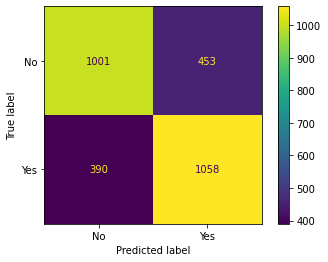

In [43]:
plot_confusion_matrix(clf_xgb, testX, testY, values_format = 'd', display_labels = ["No", "Yes"])